<center><span style="font-weight:700;font-size:40px">Домашнее задание 4</span></center>

<right><span style="font-weight:700;font-size:20px">Егоров Алексей и Половцев Александр</span></right>

<span style="font-weight:700;font-size:30px">Задание 1</span>

Подключаем необходимые библиотеки

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt

**Подготовка данных**
1. Заменим названия месяцев на их номера

2. Добавим столбец лагов t

3. Заполним пустые значения

In [3]:
df = pd.read_excel("Salt.xls")

In [4]:
df.rename(columns={'Unnamed: 0': 'year', 'Unnamed: 1': 'month'}, inplace=True)

In [5]:

df = df.assign(t = range(1, 254))
df['month'] = df['month'].replace(
    ['январь','февраль', 'март', 'апрель',
     'май', 'июнь', 'июль', 'август',
     'сентябрь', 'октябрь', 'ноябрь', 'декабрь'],
    [1,2,3,4,5,6,7,8,9,10,11,12])
df.loc[df["month"] == 'II квартал']
df = df.drop(210)

In [6]:
yr = [2002] * 252
for i in range(12, 252, 12):
    yr[i:] = [x + 1 for x in yr[i:]]
df['year'] = yr

In [7]:
df['month'] = pd.to_numeric(df['month'])
salt_median = df['salt'].median()

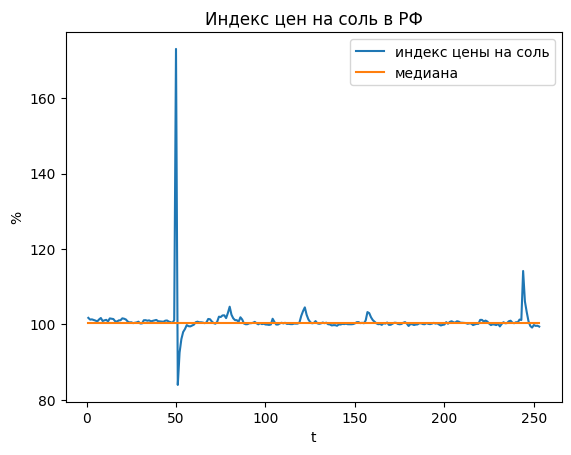

In [13]:
plt.title('Индекс цен на соль в РФ')
plt.plot(df['t'], df['salt'])
plt.plot(df['t'], [salt_median]*252)
plt.xlabel('t')
plt.ylabel('%')
plt.legend(['индекс цены на соль', 'медиана'])

<span style="font-weight:700;font-size:20px">Модель линейного тренда</span>

Проверим критерии Акайке(AIC) и Шварца(BIC)

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:              OLS              Adj. R-squared:     -0.001   
Dependent Variable: value            AIC:                1516.5582
Date:               2024-02-14 23:19 BIC:                1523.6170
No. Observations:   252              Log-Likelihood:     -756.28  
Df Model:           1                F-statistic:        0.8547   
Df Residuals:       250              Prob (F-statistic): 0.356    
R-squared:          0.003            Scale:              23.862   
-------------------------------------------------------------------
            Coef.    Std.Err.     t      P>|t|    [0.025    0.975] 
-------------------------------------------------------------------
Intercept  101.3399    0.6164  164.4180  0.0000  100.1260  102.5538
time        -0.0039    0.0042   -0.9245  0.3561   -0.0122    0.0044
------------------------------------------------------------------
Omnibus:            516.560      Durbin-Watson:         2.268     
Prob(Omnibus):      0.000        Jarque-Bera (JB):      377775.014
Skew:               12.745       Prob(JB):              0.000     
Kurtosis:           190.960      Condition No.:         293       
==================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the
errors is correctly specified.
"""

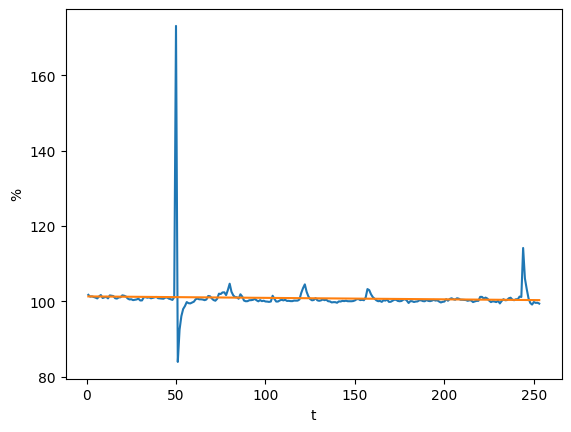

In [14]:
time = df['t']
value = df['salt']
linear_model = ols('value ~ time', data=df)
linear_trend = linear_model.fit()
pred = linear_trend.predict(df['t'])
plt.plot(df['t'], df['salt'])
plt.plot(df['t'], pred)
plt.ylabel('%')
plt.xlabel('t')
linear_trend.summary2()

**Значение AIC = 1516.56**

**Значение BIC = 1523.61**

Рассмотрим автокорреляцию остатков

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

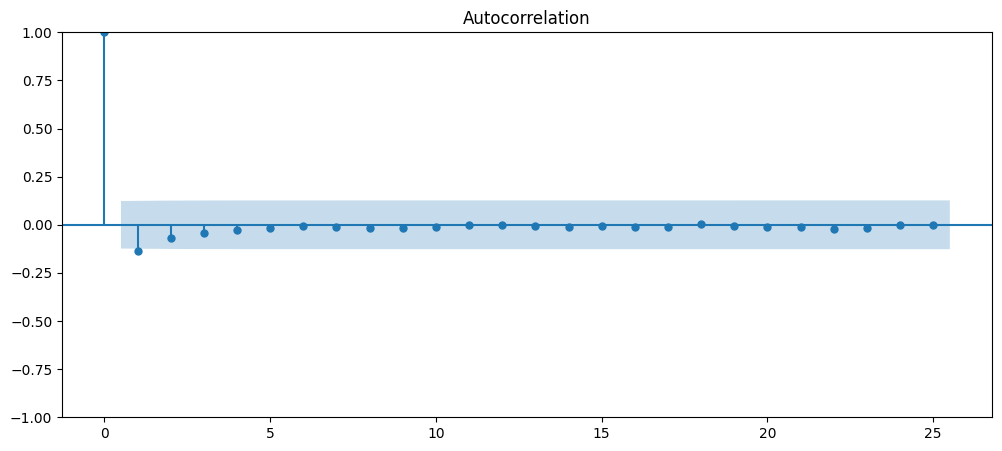

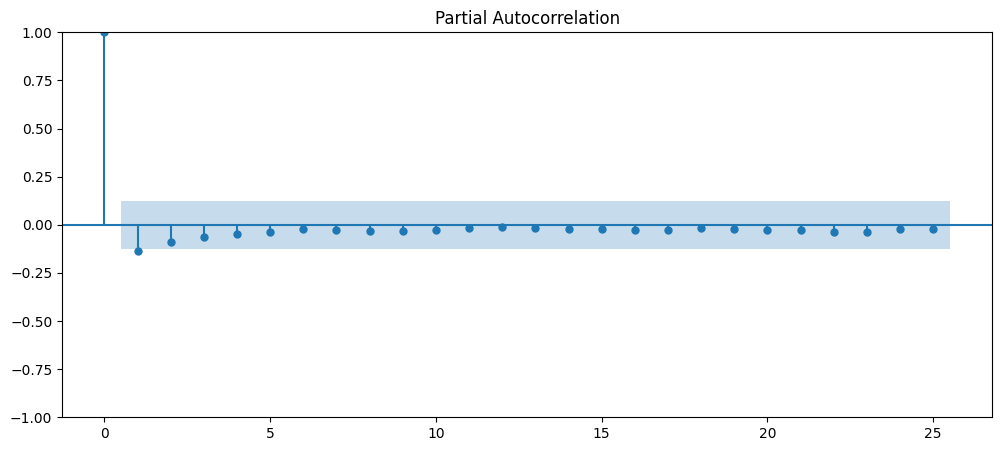

In [16]:
residuals = linear_trend.resid
plt.figure(figsize=(12,5))
plot_acf(residuals, ax=plt.gca())
plt.figure(figsize=(12,5))
plot_pacf(residuals, ax=plt.gca())
plt.show()

**Видим, что корреляция серии и её значений, сдвинутых на 1 лаг, равна 1. Это неудивительно, ведь индекс цены соли за текущий год функционально зависит от индекса цены за прошлый год. При рассмотрении лагов > 1 можем сказать, что автокорреляция отсутствует, зачит сезонности не наблюдается.**



In [17]:
l_box12 = sm.stats.acorr_ljungbox(residuals, lags=[12])
print(l_box12)
l_box = sm.stats.acorr_ljungbox(residuals)
l_box

    lb_stat  lb_pvalue
12  6.69356   0.877182


lb_stat  lb_pvalue
1   4.600222   0.031968
2   5.796557   0.055118
3   6.215907   0.101566
4   6.374612   0.172864
5   6.453014   0.264599
6   6.458816   0.373800
7   6.507213   0.481922
8   6.581160   0.582420
9   6.650551   0.673450
10  6.693277   0.754049

**Видим, что начиная с лага 2, автокорреляция остатков отсутсвует, это говорит о том, что мы не отклоняем H0, т. е. остатки для линейной модели независимы.**

**Видим, что p-value теста Льюинга-Бокса с лагом 12 больше 0.05, что говорит об отсутствии автокорреляции остатков с лагом 12, что может указывать на отсутствие сезонности.**

<span style="font-weight:700;font-size:20px">Модель парабалического тренда</span>

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:              OLS              Adj. R-squared:     -0.003   
Dependent Variable: salt             AIC:                1518.0618
Date:               2024-02-14 23:21 BIC:                1528.6501
No. Observations:   252              Log-Likelihood:     -756.03  
Df Model:           2                F-statistic:        0.6720   
Df Residuals:       249              Prob (F-statistic): 0.512    
R-squared:          0.005            Scale:              23.911   
--------------------------------------------------------------------
         Coef.     Std.Err.      t       P>|t|     [0.025    0.975] 
--------------------------------------------------------------------
const   101.8271     0.9296   109.5360   0.0000   99.9962   103.6580
t        -0.0154     0.0169    -0.9091   0.3642   -0.0487     0.0179
t^2       0.0000     0.0001     0.7007   0.4842   -0.0001     0.0002
------------------------------------------------------------------
Omnibus:            516.873      Durbin-Watson:         2.273     
Prob(Omnibus):      0.000        Jarque-Bera (JB):      379548.647
Skew:               12.760       Prob(JB):              0.000     
Kurtosis:           191.404      Condition No.:         86588     
==================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the
errors is correctly specified.
[2] The condition number is large, 8.66e+04. This might indicate
that there are strong multicollinearity or other numerical
problems.
"""

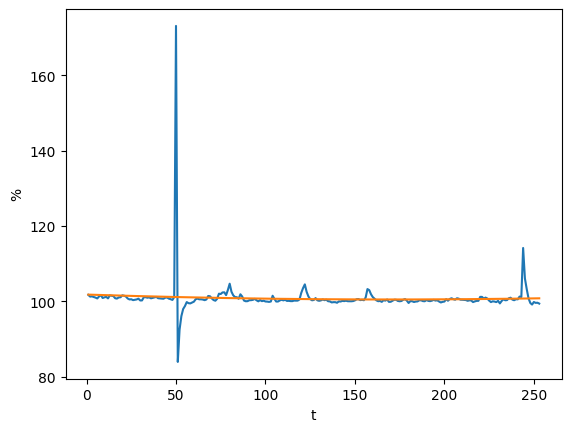

In [21]:
df['t^2'] = df['t'] ** 2
x_par = df[['t', 't^2']].copy()
x_par = sm.add_constant(x_par)
model_par = sm.OLS(df['salt'], x_par).fit()
pred_par2 = model_par.predict(x_par)

plt.plot(df['t'], df['salt'])
plt.plot(df['t'], pred_par2)
plt.ylabel('%')
plt.xlabel('t')
model_par.summary2()

**Значение AIC = 1518.0618**

**Значение BIC = 1528.6501**

**Можем видеть, что эта модель по точности почти такая же, как и прошлая, так как её значения AIC и BIC примерно на 1% выше, чем у предыдущей модели**

Рассмотрим автокорреляцию остатков

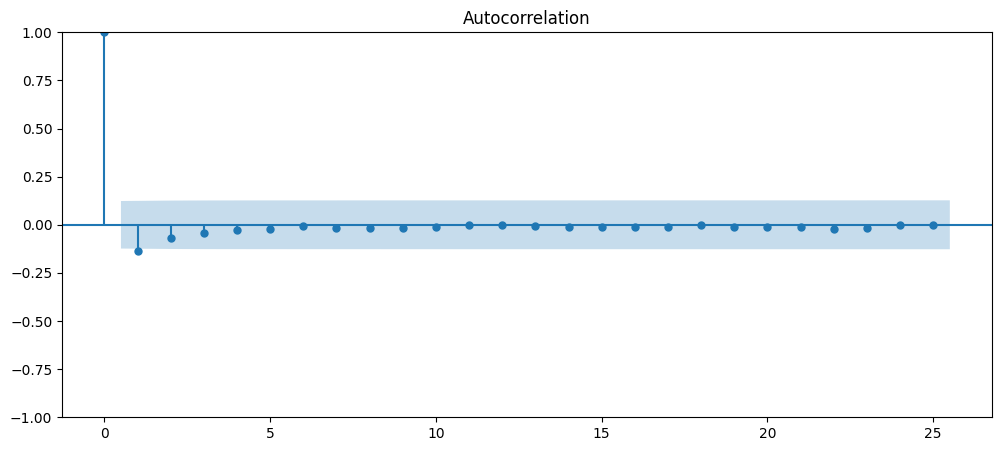

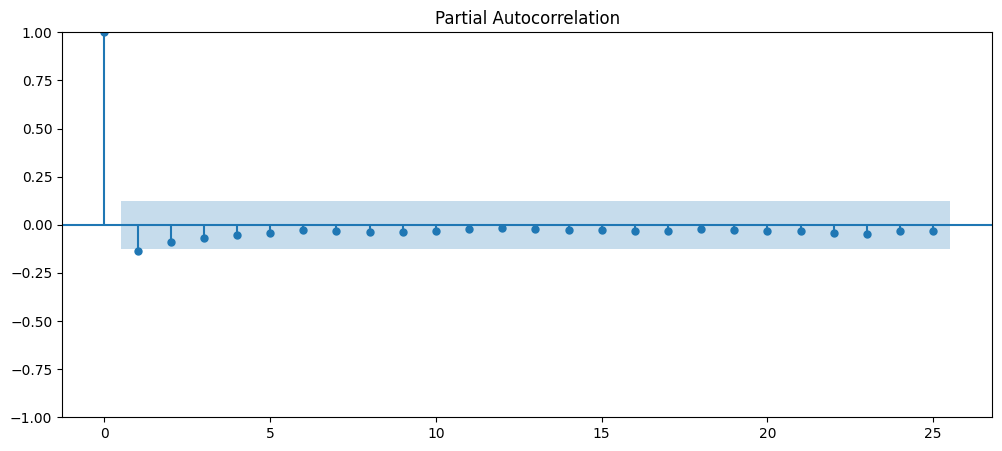

In [22]:
residuals_par = model_par.resid
plt.figure(figsize=(12,5))
plot_acf(residuals_par, ax=plt.gca())
plt.figure(figsize=(12,5))
plot_pacf(residuals_par, ax=plt.gca())
plt.show()

**Видим, что корреляция серии и её значений, сдвинутых на 1 лаг, равна 1. Это неудивительно, ведь индекс цены соли за текущий год функционально зависит от индекса цены за прошлый год. При рассмотрении лагов > 1 можем сказать, что автокорреляция отсутствует, зачит сезонности не наблюдается.**

In [23]:
l_box12_par = sm.stats.acorr_ljungbox(residuals_par, lags=[12])
print(l_box12_par)
l_box_par = sm.stats.acorr_ljungbox(residuals_par)
l_box_par

     lb_stat  lb_pvalue
12  7.122409   0.849419


lb_stat  lb_pvalue
1   4.760340   0.029123
2   6.038150   0.048846
3   6.507393   0.089371
4   6.698313   0.152716
5   6.801427   0.235832
6   6.815691   0.338229
7   6.885279   0.440922
8   6.982808   0.538489
9   7.071272   0.629699
10  7.121018   0.713973

**Видим, что начиная с лага 3, на уровне значимости 0.05 автокорреляция остатков отсутсвует, это говорит о том, что мы не отклоняем H0, т. е. остатки для линейной модели независимы.**

**Видим, что p-value теста Льюинга-Бокса с лагом 12 больше 0.05, что говорит об отсутствии автокорреляции остатков с лагом 12, что может указывать на отсутствие сезонности по годам.**

<span style="font-weight:700;font-size:20px">Модель экспоненциального тренда</span>

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:              OLS              Adj. R-squared:     -0.001   
Dependent Variable: salt_log         AIC:                -925.1534
Date:               2024-02-14 23:21 BIC:                -918.0945
No. Observations:   252              Log-Likelihood:     464.58   
Df Model:           1                F-statistic:        0.8604   
Df Residuals:       250              Prob (F-statistic): 0.355    
R-squared:          0.003            Scale:              0.0014781
-------------------------------------------------------------------
                Coef.   Std.Err.     t      P>|t|    [0.025  0.975]
-------------------------------------------------------------------
Intercept       4.6234    0.0117  394.4950  0.0000   4.6003  4.6465
t_log          -0.0023    0.0025   -0.9276  0.3545  -0.0073  0.0026
------------------------------------------------------------------
Omnibus:            476.662      Durbin-Watson:         2.304     
Prob(Omnibus):      0.000        Jarque-Bera (JB):      261719.837
Skew:               10.787       Prob(JB):              0.000     
Kurtosis:           159.398      Condition No.:         23        
==================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the
errors is correctly specified.
"""

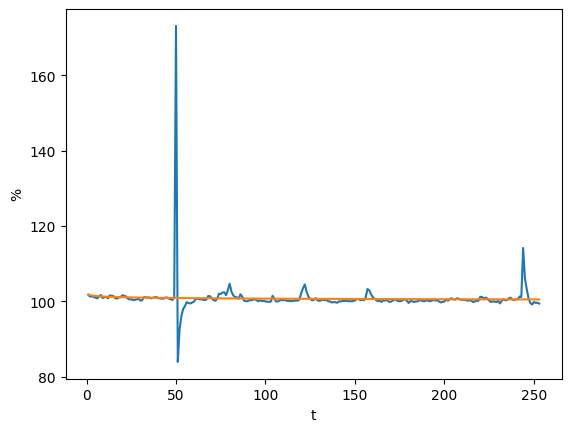

In [24]:
df['salt_log'] = np.log(df['salt'])
df['t_log'] = np.log(df['t'])
exp_model = ols("salt_log ~ t_log", data=df)
exp_trend = exp_model.fit()

pred_exp = exp_trend.predict(df['t_log'])
plt.plot(df['t'], df['salt'])
plt.plot(df['t'], np.exp(pred_exp))
plt.xlabel('t')
plt.ylabel('%')
exp_trend.summary2()

**Значение AIC = -925.1534**

**Значение BIC = -918.0945**

**Эта модель, согласно показателям AIC и BIC, является наиболее точной, т. к. модули значений этих параметров на 64% меньше, чем у предыдущих моделей.**

Рассмотрим автокорреляцию остатков

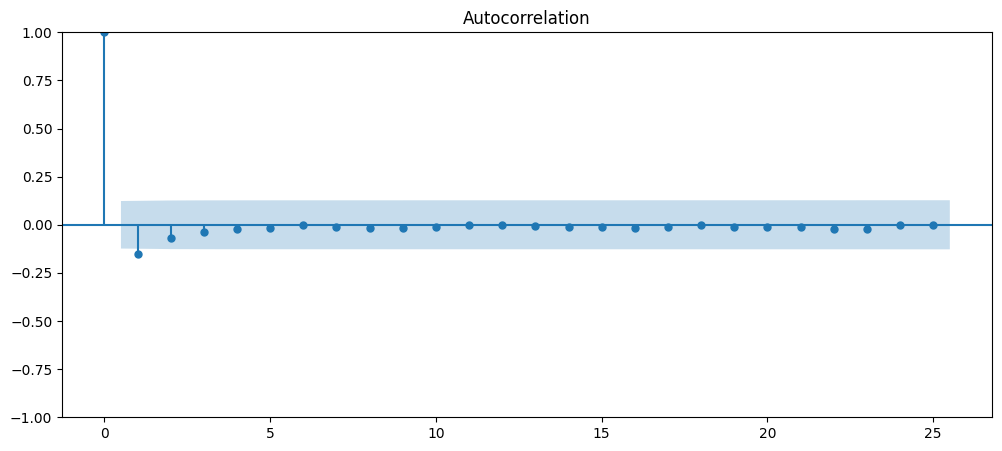

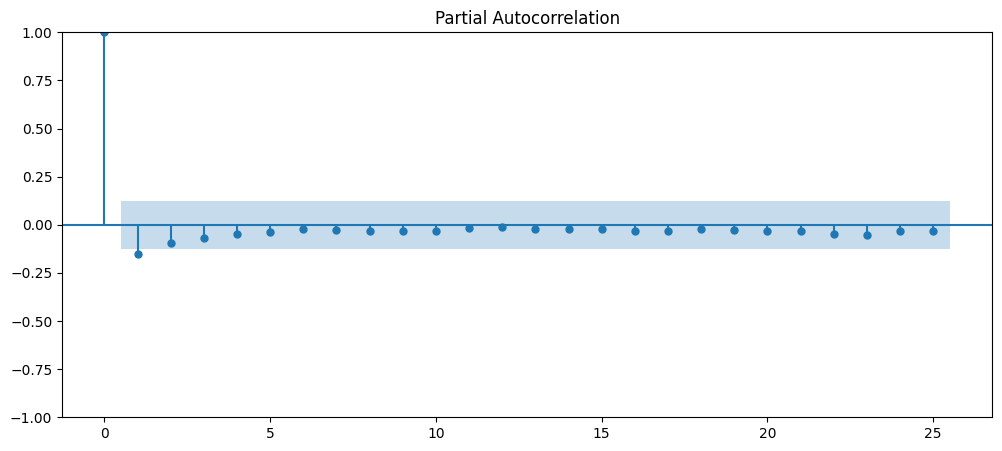

In [25]:
residuals_exp = exp_trend.resid
plt.figure(figsize=(12,5))
plot_acf(residuals_exp, ax=plt.gca())
plt.figure(figsize=(12,5))
plot_pacf(residuals_exp, ax=plt.gca())
plt.show()

In [26]:
l_box12_exp = sm.stats.acorr_ljungbox(residuals_exp, lags=[12])
print(l_box12_exp)
l_box_exp = sm.stats.acorr_ljungbox(residuals_exp)
l_box_exp

     lb_stat  lb_pvalue
12  7.954507   0.788675


lb_stat  lb_pvalue
1   5.898533   0.015154
2   7.109340   0.028591
3   7.495689   0.057669
4   7.631458   0.106050
5   7.702015   0.173441
6   7.702403   0.260727
7   7.744747   0.355639
8   7.824974   0.450751
9   7.907179   0.543527
10  7.953926   0.633338

**Видим, что начиная с лага 3, на уровне значимости 0.05 автокорреляция остатков отсутсвует, это говорит о том, что мы не отклоняем H0, т. е. остатки для линейной модели независимы.**

**Видим, что p-value теста Льюинга-Бокса с лагом 12 больше 0.05, что говорит об отсутствии автокорреляции остатков с лагом 12, что может указывать на отсутствие сезонности по годам.**

<span style="font-weight:700;font-size:20px">Выводы</span>

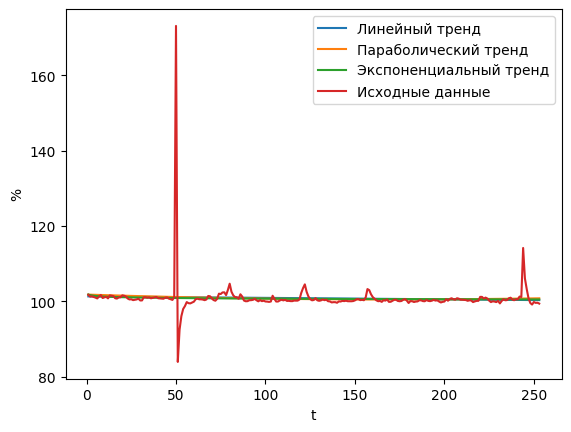

In [27]:
plt.plot(df['t'], pred, )
plt.plot(df['t'], pred_par2)
plt.plot(df['t'], np.exp(pred_exp))
plt.plot(df['t'], df['salt'])
plt.xlabel('t')
plt.ylabel('%')
plt.legend(['Линейный тренд', 'Параболический тренд', 'Экспоненциальный тренд', 'Исходные данные'])

**Все построенные модели показали приблизительно одинаковые результаты, согласно критерию R^2 они все оказались неточны (< 0.1 для всех 3 случаев). Линейная и параболическая модель, согласно тестам Акайке и Шварца, по точности оказались приблизительно равны, эскпоненциальная модель выдала более точные результаты. Все модели показали отсутствие автокорреляции у остатков, а значит остатки не являются зависимыми.**

Text(0.5, 1.0, 'Сравнение моделей')

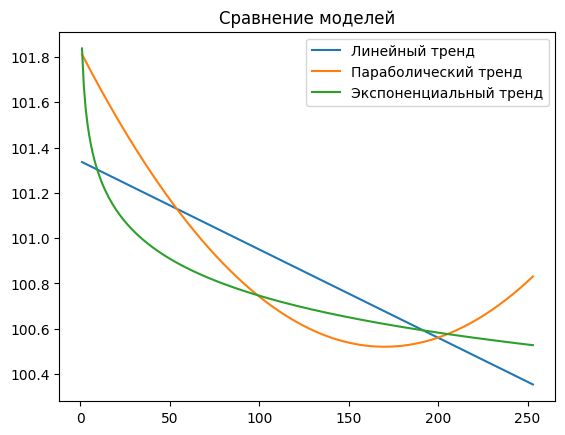

In [28]:
plt.plot(df['t'], pred)
plt.plot(df['t'], pred_par2)
plt.plot(df['t'], np.exp(pred_exp))
plt.legend(['Линейный тренд', 'Параболический тренд', 'Экспоненциальный тренд'])
plt.title('Сравнение моделей')

In [29]:
salt_max = np.max(df['salt'])
df.loc[df['salt'] == salt_max]

year  month    salt   t   t^2  salt_log     t_log
49  2006      2  173.12  50  2500  5.153985  3.912023

**В значениях индекса цен на соль в РФ есть скачёк, который не позволяет точно описать данные. Это значение индекса 173.12 в феврале 2006 года. Интересно, что в феврале 2006 года в РФ случился ["соляной кризис"](https://smertnyy.livejournal.com/20807.html), в следствие которого цены на соль резко поднялись.**

|Характеристика| Линейная модель | Параболическая модель | Экспоненциальная модель |
|----------|----------|----------|----------|
|Тест Акайке(AIC)| 1516.56   | 1518.0618   | -925.1534   |
|Тест Шварца(BIC)| 1523.61   | 1528.6501  | -918.0945   |
|Тест Льюинга-Бокса для 12 лага| 6.69356   | 7.122409    | 7.954507   |

<span style="font-weight:700;font-size:30px">Задание 2</span>

In [9]:
from scipy import stats

In [91]:
pos = 0 #найдем вершину параболы в параболической модели
pos_p2 = 0
p2 = 0
for s in pred_par2:
    if s == np.min(pred_par2):
        p2 = s
        pos_p2 = pos
    pos += 1
pos_p2

169

Выберем 3 предполагаемые точки структурного сдвига:
1. точка самого большого скачка (t = 50) 
2. вершина параболы в параболической модели (t = 169)
3. середина временного ряда (t = 126)

In [120]:
p1 = 50 #точка самого большого скачка
p2 = pos_p2 #вершина параболы в параболической модели
p3 = len(df) // 2 #середина временного ряда

In [125]:
def choy_stats(point):
    subset1 = df.iloc[:point]
    subset2 = df.iloc[point:]
    model1 = sm.OLS(subset1['salt'], sm.add_constant(subset1['t'])).fit()
    model2 = sm.OLS(subset2['salt'], sm.add_constant(subset2['t'])).fit()
    model3 = sm.OLS(df['salt'], sm.add_constant(df['t'])).fit()
    F = ((model3.ssr - (model1.ssr + model2.ssr)) / 2) /  ((model1.ssr + model2.ssr) / (len(df) - 4))
    p_value = 1 - stats.f.cdf(F, 2, len(df) - 4)
    return F, p_value

In [130]:
F1, pvalue1 = choy_stats(p1)
F2, pvalue2 = choy_stats(p2)
F3, pvalue3 = choy_stats(p3)
print(f'Для точки {p1}, статистика Чоу: {F1}, p-value: {pvalue1}')
print(f'Для точки {p2}, статистика Чоу: {F2}, p-value: {pvalue2}')
print(f'Для точки {p3}, статистика Чоу: {F3}, p-value: {pvalue3}')

Для точки 50, статистика Чоу: 9.165946744023998, p-value: 0.00014438913338732373
Для точки 169, статистика Чоу: 0.5063546022064113, p-value: 0.6033103383397214
Для точки 126, статистика Чоу: 0.4445154004520681, p-value: 0.6416447035738531


**Только для точки наибольшего скачка статистика Чоу = 9.16, p-value = 0.00014 < 0.05. Можем сказать, что на уровне значимости 0.05 точка p1 = 50 является точкой структурного сдвига. Про точки p2(169) и p3(126) мы не можем это утверждать.**

**Рассмотрим все точки выборки:**

In [129]:
for t in range(1, 252):
    F, pvalue = choy_stats(t)
    if pvalue < 0.05:
        print(f'Для точки {t}, статистика Чоу: {F}, p-value: {pvalue}')

Для точки 50, статистика Чоу: 9.165946744023998, p-value: 0.00014438913338732373
Для точки 51, статистика Чоу: 4.416330216741839, p-value: 0.013042996026840337
Для точки 242, статистика Чоу: 3.3803071836406526, p-value: 0.035612689067014536


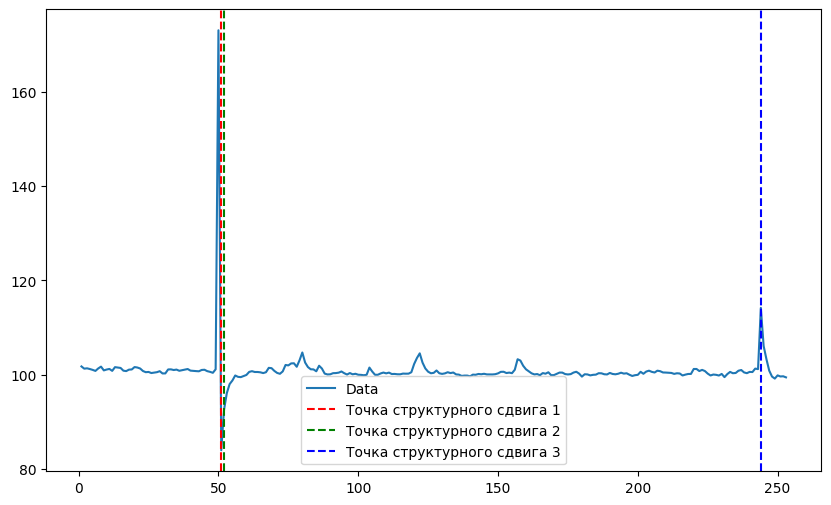

In [132]:
plt.figure(figsize=(10, 6))
plt.plot(df['t'], df['salt'], label='Data')
plt.axvline(x=df.iloc[50]['t'], color='r', linestyle='--', label='Точка структурного сдвига 1')
plt.axvline(x=df.iloc[51]['t'], color='g', linestyle='--', label='Точка структурного сдвига 2')
plt.axvline(x=df.iloc[242]['t'], color='b', linestyle='--', label='Точка структурного сдвига 3')
plt.legend()
plt.show()

**Видим, что структурный разрыв может быть в точках 50, 51, 242 на уровне значимости 0.05. В этот список попали точки 50 и 51, из-за сильного скачка, который сильно меняет параметры модели, в точке 242 также имеется сильный скачок в индексе цены на соль.**

|Точка предполагаемого структурного сдвига| статистика Чоу | p-value | Вердикт |
|----------|----------|----------|----------|
|t = 50| 9.166   | 0.0001   | Является точкой структурного сдвига   |
|t = 51| 4.416   | 4.4164  | Является точкой структурного сдвига   |
|t = 126| 0.445   | 0.6416    |Не является точкой структурного сдвига   |
|t = 169| 0.506   | 0.6033    | Не является точкой структурного сдвига   |
|t = 242| 3.380   | 0.0356    | Является точкой структурного сдвига   |

<span style="font-weight:700;font-size:30px">Задание 3</span>

In [140]:
p1_3 = 50
p2_3 = 169
p3_3 = 242

**Построим модели с использованием фиктивной переменной для 2 подтвержденных точек структурного сдвига (50 и 242) и для точки, не являющейся точкой структурного сдвига (t = 169)**

Точка t = 50

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.010    
Dependent Variable: salt             AIC:                1514.9725
Date:               2024-02-15 01:55 BIC:                1525.5608
No. Observations:   252              Log-Likelihood:     -754.49  
Df Model:           2                F-statistic:        2.216    
Df Residuals:       249              Prob (F-statistic): 0.111    
R-squared:          0.017            Scale:              23.620   
-------------------------------------------------------------------
            Coef.    Std.Err.     t      P>|t|    [0.025    0.975] 
-------------------------------------------------------------------
const      101.9667    0.6972  146.2460  0.0000  100.5934  103.3399
t            0.0038    0.0058    0.6440  0.5202   -0.0077    0.0152
dummy       -2.0013    1.0594   -1.8890  0.0601   -4.0879    0.0853
------------------------------------------------------------------
Omnibus

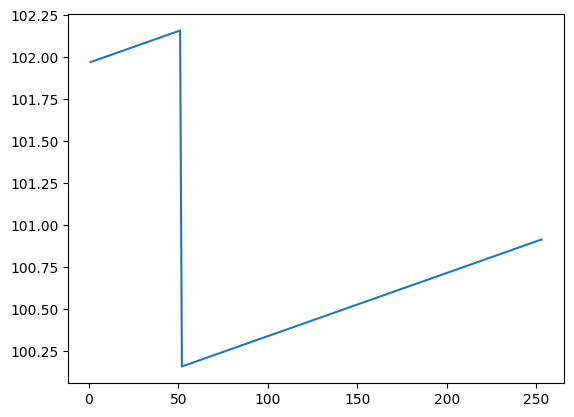

In [136]:
df2 = df.copy()
df2['dummy'] = 0
df2.loc[df.index > p1_3, 'dummy'] = 1
x_p1 = sm.add_constant(df2[['t', 'dummy']])
model_p1 = sm.OLS(df2['salt'], x_p1).fit()

pred_p1 = model_p1.predict(x_p1)

# Выведите результаты
print(model_p1.summary2())

# Постройте график остатков
# plt.figure(figsize=(10, 6))
# plt.plot(model.resid)
# plt.title('Residuals')
# plt.show()
plt.plot(df['t'], pred_p1)

Рассмотрим автокорреляцию остатков

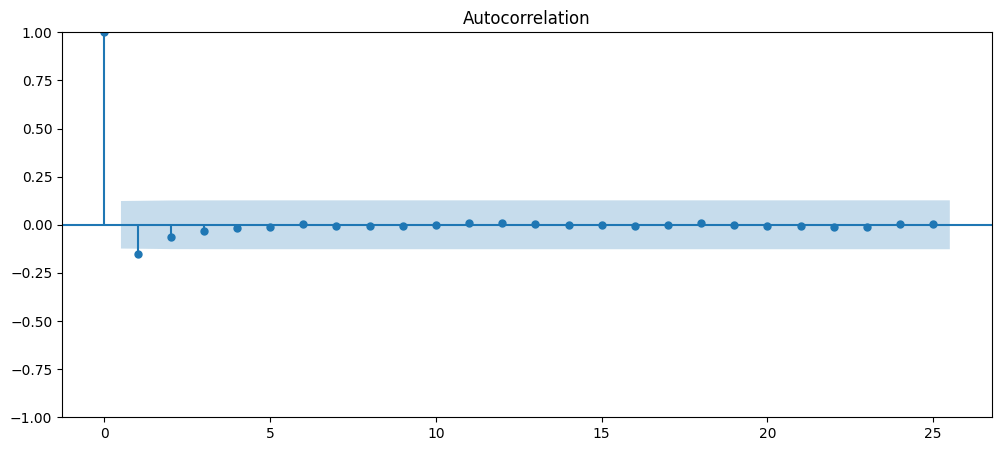

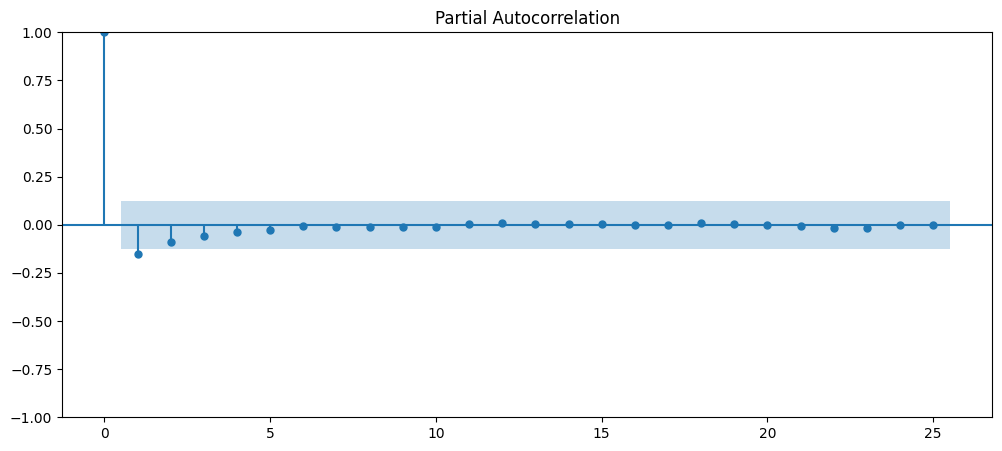

In [137]:
resid_p1 = model_p1.resid
plt.figure(figsize=(12,5))
plot_acf(resid_p1, ax=plt.gca())
plt.figure(figsize=(12,5))
plot_pacf(resid_p1, ax=plt.gca())
plt.show()

In [138]:
l_box_p1_12 = sm.stats.acorr_ljungbox(resid_p1, lags=[12])
print(l_box_p1_12)
l_box_exp_p1 = sm.stats.acorr_ljungbox(resid_p1)
l_box_exp_p1

     lb_stat  lb_pvalue
12  7.453785   0.826228


lb_stat  lb_pvalue
1   6.042801   0.013963
2   7.005056   0.030121
3   7.273969   0.063660
4   7.343744   0.118800
5   7.365799   0.194825
6   7.368991   0.288066
7   7.376441   0.390764
8   7.394106   0.494768
9   7.408008   0.594719
10  7.409959   0.686258

**Видим, что начиная с лага 3, на уровне значимости 0.05 автокорреляция остатков отсутсвует, это говорит о том, что мы не отклоняем H0, т. е. остатки для линейной модели независимы.**

**Видим, что p-value теста Льюинга-Бокса с лагом 12 больше 0.05, что говорит об отсутствии автокорреляции остатков с лагом 12, что может указывать на отсутствие сезонности по годам.**

Точка t = 169

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     -0.005   
Dependent Variable: salt             AIC:                1518.5346
Date:               2024-02-15 02:00 BIC:                1529.1229
No. Observations:   252              Log-Likelihood:     -756.27  
Df Model:           2                F-statistic:        0.4374   
Df Residuals:       249              Prob (F-statistic): 0.646    
R-squared:          0.004            Scale:              23.956   
--------------------------------------------------------------------
         Coef.     Std.Err.      t       P>|t|     [0.025    0.975] 
--------------------------------------------------------------------
const   101.3976     0.7239   140.0639   0.0000   99.9718   102.8234
t        -0.0048     0.0072    -0.6624   0.5083   -0.0191     0.0095
dummy     0.1723     1.1278     0.1527   0.8787   -2.0490     2.3936
------------------------------------------------------------------
O

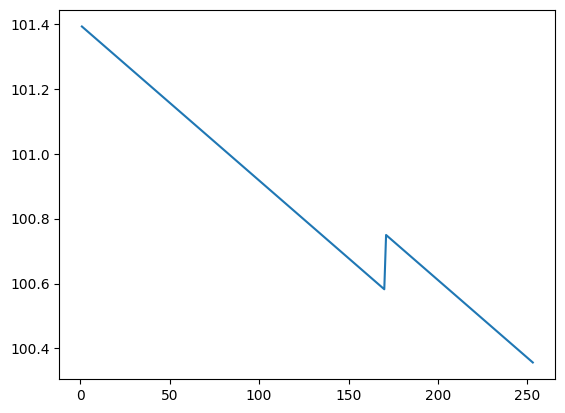

In [141]:
df2 = df.copy()
df2['dummy'] = 0
df2.loc[df.index > p2_3, 'dummy'] = 1
x_p2 = sm.add_constant(df2[['t', 'dummy']])
model_p2 = sm.OLS(df2['salt'], x_p2).fit()

pred_p2 = model_p2.predict(x_p2)

# Выведите результаты
print(model_p2.summary2())

# Постройте график остатков
# plt.figure(figsize=(10, 6))
# plt.plot(model.resid)
# plt.title('Residuals')
# plt.show()
plt.plot(df['t'], pred_p2)

Рассмотрим автокорреляцию остатков

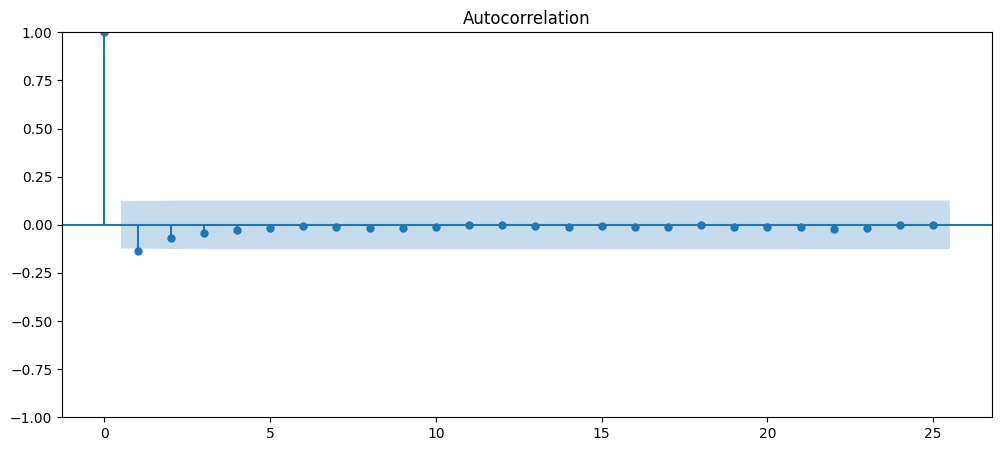

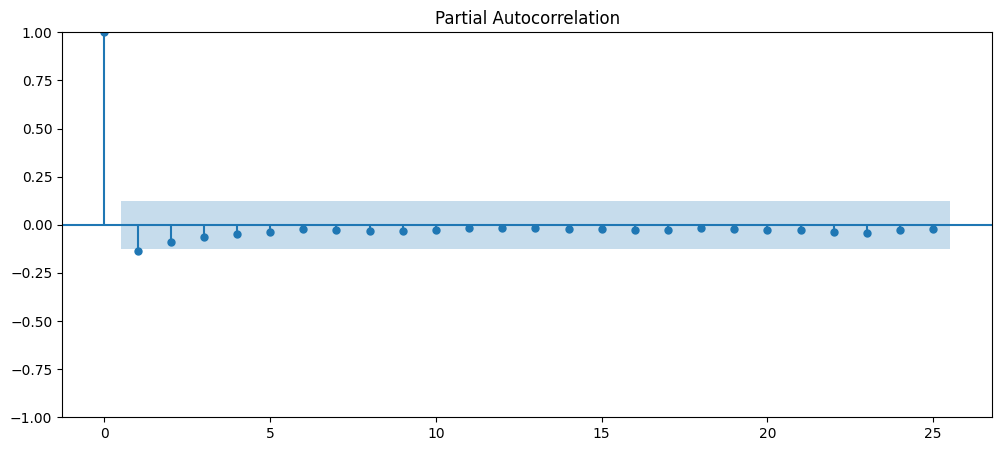

In [142]:
resid_p2 = model_p2.resid
plt.figure(figsize=(12,5))
plot_acf(resid_p2, ax=plt.gca())
plt.figure(figsize=(12,5))
plot_pacf(resid_p2, ax=plt.gca())
plt.show()

In [147]:
l_box_p2_12 = sm.stats.acorr_ljungbox(resid_p2, lags=[12])
print(l_box_p2_12)
l_box_exp_p2 = sm.stats.acorr_ljungbox(resid_p2)
l_box_exp_p2

     lb_stat  lb_pvalue
12  6.709268   0.876213


lb_stat  lb_pvalue
1   4.606875   0.031844
2   5.805928   0.054860
3   6.226917   0.101077
4   6.386678   0.172072
5   6.465934   0.263483
6   6.471965   0.372445
7   6.520963   0.480397
8   6.595473   0.580838
9   6.665449   0.671905
10  6.708844   0.752616

**Видим, что начиная с лага 2, на уровне значимости 0.05 автокорреляция остатков отсутсвует, это говорит о том, что мы не отклоняем H0, т. е. остатки для линейной модели независимы.**

**Видим, что p-value теста Льюинга-Бокса с лагом 12 больше 0.05, что говорит об отсутствии автокорреляции остатков с лагом 12, что может указывать на отсутствие сезонности по годам.**

Точка t = 242

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.002    
Dependent Variable: salt             AIC:                1516.9284
Date:               2024-02-15 02:07 BIC:                1527.5167
No. Observations:   252              Log-Likelihood:     -755.46  
Df Model:           2                F-statistic:        1.236    
Df Residuals:       249              Prob (F-statistic): 0.292    
R-squared:          0.010            Scale:              23.804   
-------------------------------------------------------------------
            Coef.    Std.Err.     t      P>|t|    [0.025    0.975] 
-------------------------------------------------------------------
const      101.5000    0.6284  161.5321  0.0000  100.2624  102.7376
t           -0.0058    0.0045   -1.3020  0.1941   -0.0146    0.0030
dummy        2.1274    1.6737    1.2711  0.2049   -1.1690    5.4238
------------------------------------------------------------------
Omnibus

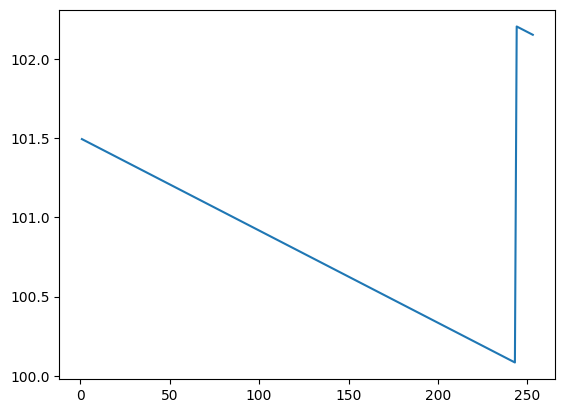

In [144]:
df2 = df.copy()
df2['dummy'] = 0
df2.loc[df.index > p3_3, 'dummy'] = 1
x_p3 = sm.add_constant(df2[['t', 'dummy']])
model_p3 = sm.OLS(df2['salt'], x_p3).fit()

pred_p3 = model_p3.predict(x_p3)

# Выведите результаты
print(model_p3.summary2())

# Постройте график остатков
# plt.figure(figsize=(10, 6))
# plt.plot(model.resid)
# plt.title('Residuals')
# plt.show()
plt.plot(df['t'], pred_p3)

Рассмотрим автокорреляцию остатков

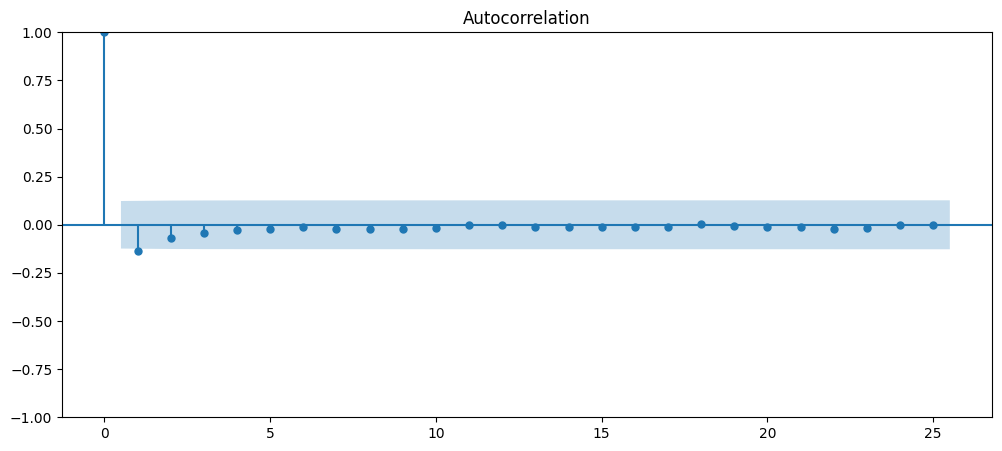

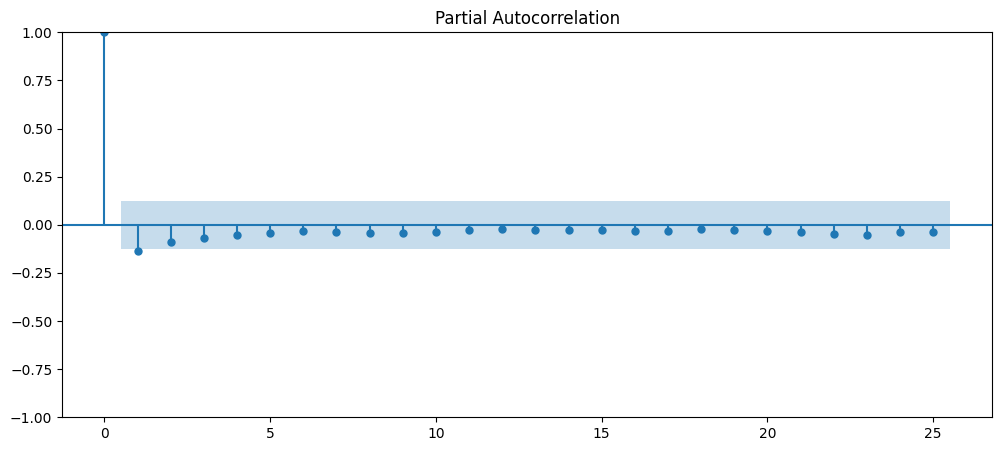

In [145]:
resid_p3 = model_p3.resid
plt.figure(figsize=(12,5))
plot_acf(resid_p3, ax=plt.gca())
plt.figure(figsize=(12,5))
plot_pacf(resid_p3, ax=plt.gca())
plt.show()

In [146]:
l_box_p3_12 = sm.stats.acorr_ljungbox(resid_p3, lags=[12])
print(l_box_p3_12)
l_box_exp_p3 = sm.stats.acorr_ljungbox(resid_p3)
l_box_exp_p3

     lb_stat  lb_pvalue
12  7.354825   0.833302


lb_stat  lb_pvalue
1   4.851119   0.027628
2   6.130166   0.046650
3   6.592651   0.086079
4   6.786824   0.147592
5   6.903810   0.227893
6   6.929041   0.327459
7   7.030316   0.425730
8   7.169766   0.518432
9   7.293229   0.606619
10  7.351701   0.691877

**Видим, что начиная с лага 3, на уровне значимости 0.05 автокорреляция остатков отсутсвует, это говорит о том, что мы не отклоняем H0, т. е. остатки для линейной модели независимы.**

**Видим, что p-value теста Льюинга-Бокса с лагом 12 больше 0.05, что говорит об отсутствии автокорреляции остатков с лагом 12, что может указывать на отсутствие сезонности по годам.**

<span style="font-weight:700;font-size:20px">Выводы</span>

**Для точек p1(t=50), p2(t=169), p3(t=242) были построены регрессионные модели с использованием фиктивных переменных.
По графикам предсказанных значений можем понять, что графики для точек p1 и p3 содержат больший перепед значения индекса цен на соль, что подтверждает нашу гипотезу о том, что эти точки действительно являются точками структурного сдвига. Для точки p2(t =169) мы этого сказать не можем, так как предполагаемый разрыв не такой силы, сравнительно с предыдущими графиками. Все модели являются адекватными с точки зрения автокорреляции остатков и теста Льюинга-Бокса.**